In [1]:
# 0. 사용 라이브러리 불러오기
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc
import re

%matplotlib inline


In [2]:
#1. 데이터 준비
df = pd.read_csv('KRvideos_ANSI.csv',encoding = 'cp949')
df.head()

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count
0,18.19.02,10,2011-09-29T13:08:39.000Z,56227,690,15,66
1,18.20.02,10,2011-09-29T13:08:39.000Z,72564,920,15,79
2,18.21.02,10,2011-09-29T13:08:39.000Z,82500,1029,14,88
3,17.14.11,22,2014-09-21T02:32:35.000Z,16273,0,1,1
4,17.22.12,22,2014-10-05T09:33:52.000Z,79566,1218,11,50


In [3]:
#4. datetime포맷으로 변경하기.
''' 우선 trending_date - 인기 날짜 부터  '''
df.trending_date=pd.to_datetime(df.trending_date,format='%y.%d.%m')
# trending_date에 따라 sorting하기.
df.sort_values(by='trending_date', axis=0, inplace=True)
df

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count
319,2017-11-14,24,2017-11-13T10:33:19.000Z,182505,6309,165,1737
168,2017-11-14,24,2017-11-12T07:48:04.000Z,83873,428,82,240
169,2017-11-14,22,2017-11-12T07:57:28.000Z,13201,1055,2,130
170,2017-11-14,23,2017-11-12T07:58:45.000Z,31433,175,27,93
171,2017-11-14,24,2017-11-12T08:00:02.000Z,17568,141,3,108
...,...,...,...,...,...,...,...
34205,2018-06-14,24,2018-06-10T23:00:01.000Z,156439,383,58,308
34433,2018-06-14,23,2018-06-12T09:38:25.000Z,114203,1660,65,417
34435,2018-06-14,1,2018-06-12T09:54:50.000Z,52623,1347,34,428
34423,2018-06-14,20,2018-06-12T09:01:40.000Z,685428,14737,765,3355


In [4]:
# train, test 만들기 - trending_data 기반.
df_train=df[df.trending_date<'2018-05-01'].copy()
df_test=df[df.trending_date>='2018-05-01'].copy()

del df
gc.collect()
# 330

27

In [5]:
df_train

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count
319,2017-11-14,24,2017-11-13T10:33:19.000Z,182505,6309,165,1737
168,2017-11-14,24,2017-11-12T07:48:04.000Z,83873,428,82,240
169,2017-11-14,22,2017-11-12T07:57:28.000Z,13201,1055,2,130
170,2017-11-14,23,2017-11-12T07:58:45.000Z,31433,175,27,93
171,2017-11-14,24,2017-11-12T08:00:02.000Z,17568,141,3,108
...,...,...,...,...,...,...,...
26654,2018-04-30,25,2018-04-27T14:36:14.000Z,233397,0,0,1530
26691,2018-04-30,24,2018-04-28T00:00:53.000Z,252193,6304,119,2165
26444,2018-04-30,1,2018-04-27T00:44:41.000Z,86352,326,18,45
26374,2018-04-30,24,2018-04-26T10:01:13.000Z,906332,11287,796,3493


In [6]:
# target feature - views - 구분하기
y_train=df_train.views.values
y_test=df_test.views.values

del df_train['views'], df_test['views']
gc.collect()

X_train=df_train.copy()
X_test=df_test.copy()

del df_train,df_test
gc.collect()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26767, 6), (7800, 6), (26767,), (7800,))

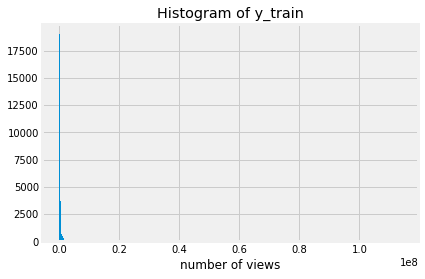

In [7]:
fig,ax=plt.subplots()
ax.hist(y_train,bins=500)
ax.set_xlabel('number of views')
ax.set_title('Histogram of y_train');

히스토그램을 통해 views(조회수)의 범위, 고르지 않은 분포를 볼 수 있다.
따라서 조회수에 대해 로그 변환 실시함. 

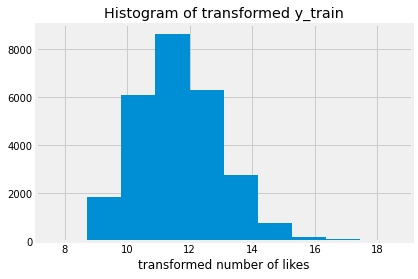

In [8]:
# Log transformation of the train-target feature
fig,ax=plt.subplots()
ax.hist(np.log(y_train+1))
ax.set_xlabel('transformed number of likes')
ax.set_title('Histogram of transformed y_train');

정규 분포에 가까운 형태로 변환된 것을 볼 수 있음.

In [9]:
# 조회수 이외의 좋아요, 댓글수도 로그변환하여 업데이트 시킴. 

X_train['likes']=np.log(X_train['likes']+1)
X_train['comment_count']=np.log(X_train['comment_count']+1)

X_test['likes']=np.log(X_test['likes']+1)
X_test['comment_count']=np.log(X_test['comment_count']+1)

train=X_train.copy()
train['views']=np.log(y_train+1)

test=X_test.copy()

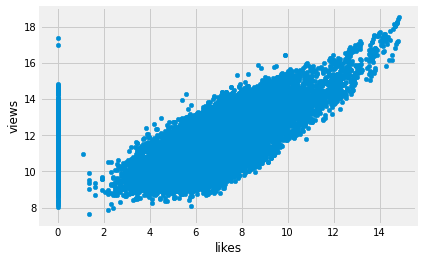

In [10]:
train.plot.scatter(x='likes',y='views');

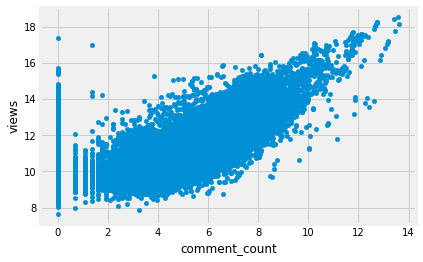

In [11]:
train.plot.scatter(x='comment_count',y='views');

Baseline 선형 회귀 모델 학습

In [12]:
X_train=train[['likes','comment_count', 'dislikes', 'category_id']]
X_test = test[['likes','comment_count', 'dislikes', 'category_id']]

In [13]:
train_rows=X_train.shape[0]
data=pd.concat([X_train,X_test])

data=pd.get_dummies(data)

X_train=data[:train_rows].copy()
X_test=data[train_rows:].copy()

del data
gc.collect()

X_train.shape,X_test.shape
#((26767, 3), (7800, 3))

((26767, 4), (7800, 4))

In [14]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 1, solver = "cholesky") # 처음엔 숄레스키 분해("cholesky")


ridge.fit(X_train,np.log(y_train+1))



ridge.score(X_test,np.log(y_test+1))



0.5453477210299797

In [15]:
## 라쏘 회귀 사용

from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train,np.log(y_train+1))
lasso_reg.score(X_train,np.log(y_train+1))

0.5116225858863819

In [16]:
## elastic net
from sklearn.linear_model import ElasticNet
el = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
el.fit(X_train,np.log(y_train+1))
el.score(X_train,np.log(y_train+1))

0.5126272375223535

In [17]:
# Baseline linear regression model
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train,np.log(y_train+1))
print("Training score")
lr.score(X_train,np.log(y_train+1))
print("\n Test score")
lr.score(X_test,np.log(y_test+1))


Training score

 Test score


0.5453475135526422

     |████████████████████████████████| 542kB 7.8MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=f5a65c80a2da140a19aa6f57d8c5008593059185d249f1fba59545e0ce46e261
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn
w[0]: 0.393906  b: -0.031804


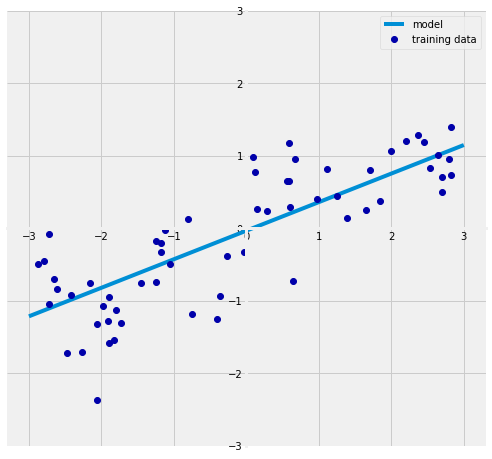

In [18]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install mglearn
import mglearn
mglearn.plots.plot_linear_regression_wave()

In [19]:
lr.score(X_train,np.log(y_train+1))

0.5134435667794512

In [20]:
# Predicting views next two months of trending videos
from sklearn import metrics

y_pred=ridge.predict(X_test)
y_pred=np.exp(y_pred)-1
metrics.mean_absolute_error(y_test,y_pred)

299370.7021514555